In [1]:
import glob
import os
import pickle
import librosa
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import sagemaker

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

In [4]:
def build_files_list(root_dir, normal_dir='normal', abnormal_dir='abnormal'):
    normal_files = []
    abnormal_files = []

    for root, dirs, files in os.walk(root_dir):
        current_dir_type = os.path.basename(root)
        if current_dir_type == normal_dir:
            normal_files.extend([os.path.join(root, name) for name in files])
        elif current_dir_type == abnormal_dir:
            abnormal_files.extend([os.path.join(root, name) for name in files])

    return normal_files, abnormal_files

def extract_signal_features(signal, sr, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels
    
    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)
    
    features = np.zeros((features_vector_size, dims), np.float32)
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T
        
    return features


def generate_dataset(files_list, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    dims = n_mels * frames
    
    for index in tqdm(range(len(files_list)), desc='Extracting Features'):
        signal, sr = load_sound_file(files_list[index])
        features = extract_signal_features(
            signal, 
            sr, 
            n_fft=n_fft, 
            hop_length=hop_length,
            n_mels=n_mels, 
            frames=frames
        )
        
        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)
            
        dataset[features.shape[0] * index : features.shape[0] * (index + 1), :] = features

    return dataset


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


def load_sound_file(path, mono=False, channel=0):
    signal, sr = librosa.load(path, sr=None, mono=mono)
    
    if signal.ndim < 2:
        return signal, sr
    else:
        return signal[channel, :], sr

In [5]:
DATA_PATH = '../mimii-anomaly-detection'
MODEL_PATH = './models'

file_paths = sorted(glob.glob('{}/*/*'.format(DATA_PATH)))
file_path = file_paths[0]
print(file_paths)

['../mimii-anomaly-detection\\dataset2\\test_files__mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset2\\test_labels__mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset2\\train_data__mimii-anomaly-detection.pkl', '../mimii-anomaly-detection\\dataset2\\train_files__mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset2\\train_labels__mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset\\test_files_mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset\\test_labels_mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset\\train_data_mimii-anomaly-detection.pkl', '../mimii-anomaly-detection\\dataset\\train_files_mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\dataset\\train_labels_mimii-anomaly-detection.txt', '../mimii-anomaly-detection\\pump\\id_00', '../mimii-anomaly-detection\\pump\\id_02', '../mimii-anomaly-detection\\pump\\id_04', '../mimii-anomaly-detection\\pump\\id_06']


In [6]:
all_normal_files = []
all_abnormal_files = []

for file_path in file_paths:
    normal_files, abnormal_files = build_files_list(root_dir=file_path)
    all_normal_files.extend(normal_files)
    all_abnormal_files.extend(abnormal_files)

X = np.concatenate((all_normal_files, all_abnormal_files), axis=0)
y = np.concatenate((np.zeros(len(all_normal_files)), np.ones(len(all_abnormal_files))), axis=0)
train_files, test_files, train_labels, test_labels = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True, stratify=y)
 

In [7]:
print('Train set has {} signals including abnormal {:.0f} signals, but test set has {} signals including abnormal {:.0f} signals.'.format(
    train_labels.shape[0], train_labels.sum(), test_labels.shape[0], test_labels.sum()))

Train set has 3364 signals including abnormal 365 signals, but test set has 841 signals including abnormal 91 signals.


In [8]:
os.makedirs(os.path.join(DATA_PATH, 'dataset2'), exist_ok=True)
file_path = os.path.normpath(file_path)
file_path_split = file_path.split(os.path.sep)
suffix = "_" + file_path_split[1]

dataset = {
    'train_files': train_files,
    'test_files': test_files,
    'train_labels': train_labels,
    'test_labels': test_labels
}

for key, values in dataset.items():
    file_name = os.path.join(DATA_PATH, 'dataset2', key + '_' + suffix + '.txt')
    with open(file_name, 'w') as f:
        for item in values:
            f.write(str(item) + '\n')

In [9]:
train_files = [file for file in train_files if file not in abnormal_files]
train_labels = np.zeros(len(train_files))

In [10]:
train_data_path = os.path.join(DATA_PATH, 'dataset2', 'train_data_' + suffix + '.pkl')

n_fft = 2048
hop_length = 512
n_mels = 64
frames = 5

if os.path.exists(train_data_path):
    print('Train data already exists, loading from file...')
    with open(train_data_path, 'rb') as f:
        train_data = pickle.load(f)
        
else:
    train_data = generate_dataset(train_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames)
    print('Saving training data to disk...')
    with open(train_data_path, 'wb') as f:
        pickle.dump(train_data, f)
    print('Done.')

print(f'Train data has a {train_data.shape} shape.')

Train data already exists, loading from file...
Train data has a (1013520, 320) shape.


In [11]:
def autoencoder(input_dims):
    input_layer = Input(shape=(input_dims,))
    h = Dense(64, activation='relu')(input_layer)
    h = Dense(64, activation='relu')(h)
    h = Dense(8, activation='relu')(h)
    h = Dense(64, activation='relu')(h)
    h = Dense(64, activation='relu')(h)
    h = Dense(input_dims, activation=None)(h)
    
    return Model(inputs=input_layer, outputs=h, name='autoencoder')

In [12]:
model = autoencoder(n_mels * frames)

print(model.summary())

gpu_count = len(get_available_gpus())
if gpu_count > 1:
    model = multi_gpu_model(model, gpus=gpu_count)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                20544     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
________________________________________

In [14]:
batch_size = 512
epochs = 100

model.compile(
    optimizer=Adam(learning_rate=1e-03),
    loss='mean_squared_error'
)

history = model.fit(
    train_data, 
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    validation_split=0.2,
    verbose=True,
    shuffle=True
)

os.makedirs(MODEL_PATH, exist_ok=True)
model.save(os.path.join(MODEL_PATH, 'autoencoder' + '_' + suffix + '.h5'))

Train on 810816 samples, validate on 202704 samples
Epoch 1/100
810816/810816 [==============================] - 18s 23us/sample - loss: 4.3984 - val_loss: 4.5863
Epoch 2/100
810816/810816 [==============================] - 11s 14us/sample - loss: 4.3864 - val_loss: 4.6353
Epoch 3/100
810816/810816 [==============================] - 11s 13us/sample - loss: 4.3847 - val_loss: 4.6023
Epoch 4/100
810816/810816 [==============================] - 13s 16us/sample - loss: 4.3840 - val_loss: 4.5931
Epoch 5/100
810816/810816 [==============================] - 14s 17us/sample - loss: 4.3807 - val_loss: 4.5912
Epoch 6/100
810816/810816 [==============================] - 12s 15us/sample - loss: 4.3797 - val_loss: 4.5848
Epoch 7/100
810816/810816 [==============================] - 13s 17us/sample - loss: 4.3792 - val_loss: 4.5905
Epoch 8/100
810816/810816 [==============================] - 13s 15us/sample - loss: 4.3761 - val_loss: 4.5745
Epoch 9/100
810816/810816 [==============================] -

In [15]:
reconstruction_errors = []

for index in tqdm(range(len(test_files))):
    signal, sr = load_sound_file(test_files[index])
    
    features = extract_signal_features(
        signal, 
        sr, 
        n_fft=n_fft, 
        hop_length=hop_length,
        n_mels=n_mels, 
        frames=frames
    )
    
    prediction = model.predict(features)
    mse = np.mean(np.mean(np.square(features - prediction), axis=1))
    reconstruction_errors.append(mse)

  0%|          | 0/841 [00:00<?, ?it/s]

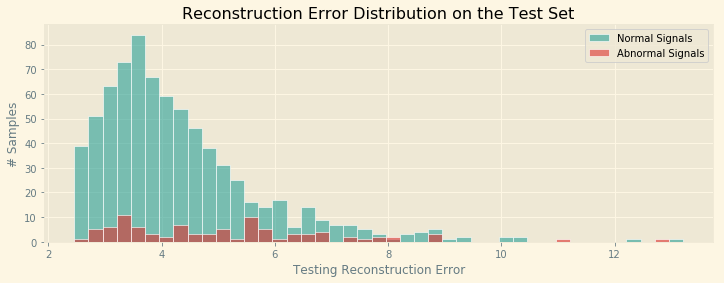

In [78]:
y_true = test_labels
data = np.column_stack((range(len(reconstruction_errors)), reconstruction_errors))
bin_width = 0.25
bins = np.arange(min(reconstruction_errors), max(reconstruction_errors) + bin_width, bin_width)

fig = plt.figure(figsize=(12,4))
plt.hist(data[y_true == 0][:, 1], bins=bins, color=colors[1], alpha=0.6, label='Normal Signals', edgecolor='#FFFFFF')
plt.hist(data[y_true == 1][:, 1], bins=bins, color=colors[5], alpha=0.6, label='Abnormal Signals', edgecolor='#FFFFFF')
plt.xlabel("Testing Reconstruction Error")
plt.ylabel("# Samples")
plt.title('Reconstruction Error Distribution on the Test Set', fontsize=16)
plt.legend()
plt.show()

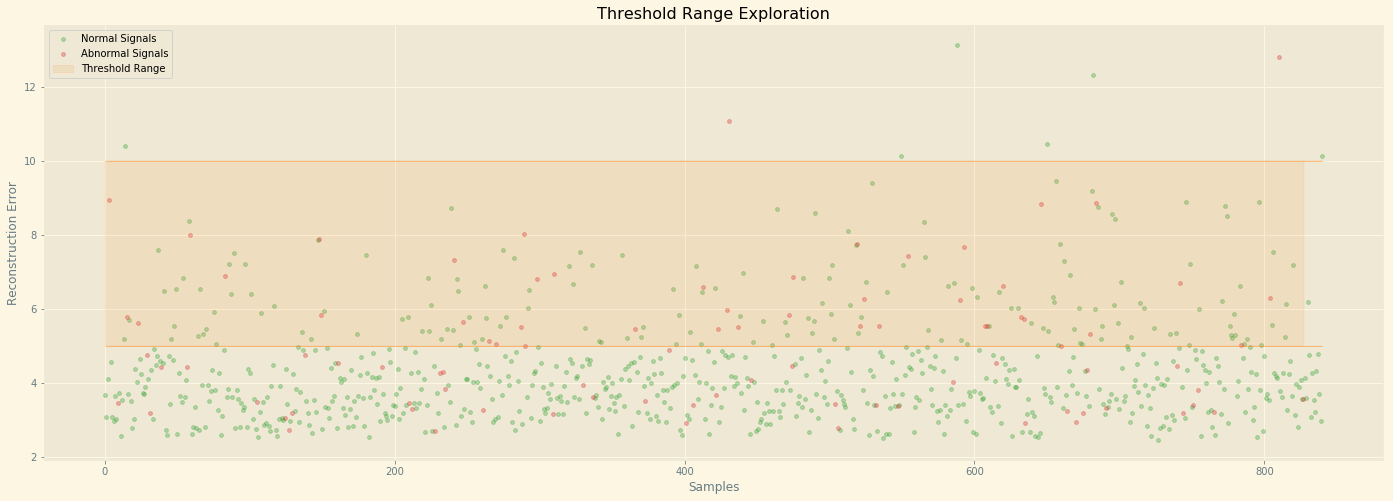

In [79]:
threshold_min = 5.0
threshold_max = 10.0
threshold_step = 0.50

normal_x, normal_y = data[y_true==0][:,0], data[y_true==0][:,1]
abnormal_x, abnormal_y = data[y_true==1][:,0], data[y_true==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24,8))
plt.scatter(normal_x, normal_y, s=15, color='tab:green', alpha=0.3, label='Normal Signals')
plt.scatter(abnormal_x, abnormal_y, s=15, color='tab:red', alpha=0.3, label='Abnormal Signals')
plt.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='tab:orange', label='Threshold Range')
plt.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='tab:orange')
plt.legend(loc='upper left')
plt.title('Threshold Range Exploration', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.show()

In [80]:
def generate_error_types(df, ground_truth_col='Ground Truth', prediction_col='Prediction', normal_label=0.0, anomaly_label=1.0):
    """
    Compute false positive and false negatives columns based on the prediction
    and ground truth columns from a dataframe.
    
    PARAMS
    ======
        df (dataframe)
            Dataframe where the ground truth and prediction columns are available
        ground_truth_col (string)
            Column name for the ground truth values. Defaults to "Ground Truth"
        prediction_col (string)
            Column name for the predictied values. Defaults to "Prediction"
        normal_label (object)
            Value taken by a normal value. Defaults to 0.0
        anomaly_label (object)
            Value taken by an abnormal value. Defaults to 1.0
            
    RETURNS
    =======
        df (dataframe)
            An updated dataframe with 4 new binary columns for TP, TN, FP and FN.
    """
    df['TP'] = 0
    df['TN'] = 0
    df['FP'] = 0
    df['FN'] = 0
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == normal_label), 'TP'] = 1
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'TN'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == normal_label), 'FP'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'FN'] = 1
    
    return df

def plot_curves(FP, FN, nb_samples, threshold_min, threshold_max, threshold_step):
    """
    Plot the false positives and false negative samples number depending on a given threshold.
    
    PARAMS
    ======
        FP (dataframe)
            Number of false positives depending on the threshold
        FN (dataframe)
            Number of false negatives depending on the threshold
        threshold_min (float)
            Minimum threshold to plot for
        threshold_max (float)
            Maximum threshold to plot for
        threshold_step (float)
            Threshold step to plot these curves
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    min_FN = np.argmin(FN)
    min_FP = np.where(FP == np.min(FP))[0][-1]
    plot_top = max(FP + FN) + 1

    # Grid customization:
    major_ticks = np.arange(threshold_min, threshold_max, 1.0 * threshold_step)
    minor_ticks = np.arange(threshold_min, threshold_max, 0.2 * threshold_step)
    ax.set_xticks(major_ticks);
    ax.set_xticks(minor_ticks, minor=True);
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1.0, linewidth=1.0)
    
    # Plot false positives and false negatives curves
    plt.plot(np.arange(threshold_min, threshold_max + threshold_step, threshold_step), FP, label='False positive', color='tab:red')
    plt.plot(np.arange(threshold_min, threshold_max + threshold_step, threshold_step), FN, label='False negative', color='tab:green')

    # Finalize the plot with labels and legend:
    plt.xlabel('Reconstruction error threshold (%)', fontsize=16)
    plt.ylabel('# Samples', fontsize=16)
    plt.legend()
    
    
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a heatmap.
    
    PARAMS
    ======
        confusion_matrix (numpy.ndarray)
            The numpy.ndarray object returned from a call to 
            sklearn.metrics.confusion_matrix. Similarly constructed 
            ndarrays can also be used.
        class_names (list)
            An ordered list of class names, in the order they index the given
            confusion matrix.
        figsize (tuple)
            A 2-long tuple, the first value determining the horizontal size of
            the ouputted figure, the second determining the vertical size.
            Defaults to (10,7).
        fontsize: (int)
            Font size for axes labels. Defaults to 14.
        
    RETURNS
    =======
        matplotlib.figure.Figure: The resulting confusion matrix figure
    """
    # Build a dataframe from the confusion matrix passed as argument:
    df_cm = pd.DataFrame(confusion_matrix, 
                         index=class_names, 
                         columns=class_names)
    
    # Plot the confusion matrix:
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}, cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    # Figure customization:
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    
    return fig

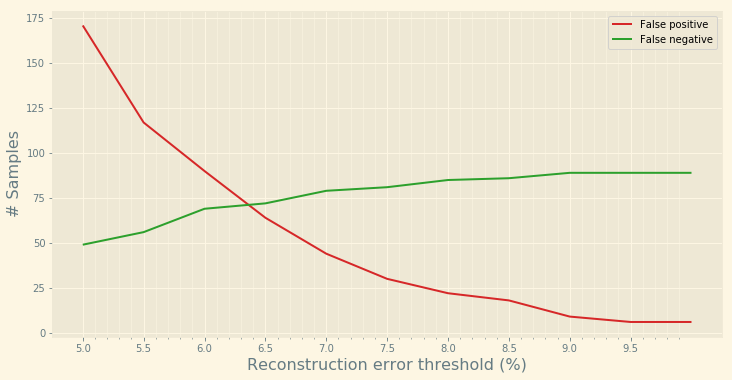

In [81]:
import pandas as pd
thresholds = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)

df = pd.DataFrame(columns=['Signal', 'Ground Truth', 'Prediction', 'Reconstruction Error'])
df['Signal'] = test_files
df['Ground Truth'] = test_labels
df['Reconstruction Error'] = reconstruction_errors

FN = []
FP = []
for th in thresholds:
    df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
    df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
    df = generate_error_types(df)
    FN.append(df['FN'].sum())
    FP.append(df['FP'].sum())
        
plot_curves(FP, FN, nb_samples=df.shape[0], threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step)

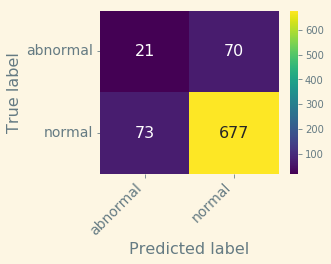

In [83]:
import seaborn as sns

th = 6.275
df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
df['Prediction'] = df['Prediction'].astype(np.float32)
df = generate_error_types(df)
tp = df['TP'].sum()
tn = df['TN'].sum()
fn = df['FN'].sum()
fp = df['FP'].sum()

from sklearn.metrics import confusion_matrix
df['Ground Truth'] = 1 - df['Ground Truth']
df['Prediction'] = 1 - df['Prediction']
print_confusion_matrix(confusion_matrix(df['Ground Truth'], df['Prediction']), class_names=['abnormal', 'normal']);



In [84]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print(f"""Basic autoencoder metrics:
- Precision: {precision*100:.1f}%
- Recall: {recall*100:.1f}%
- Accuracy: {accuracy*100:.1f}%
- F1 Score: {f1_score*100:.1f}%""")



Basic autoencoder metrics:
- Precision: 90.3%
- Recall: 90.6%
- Accuracy: 83.0%
- F1 Score: 90.4%


In [85]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, reconstruction_errors)

0.6249230769230769

In [86]:
class visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save .png file path.
        return : None
        """
        self.plt.savefig(name)

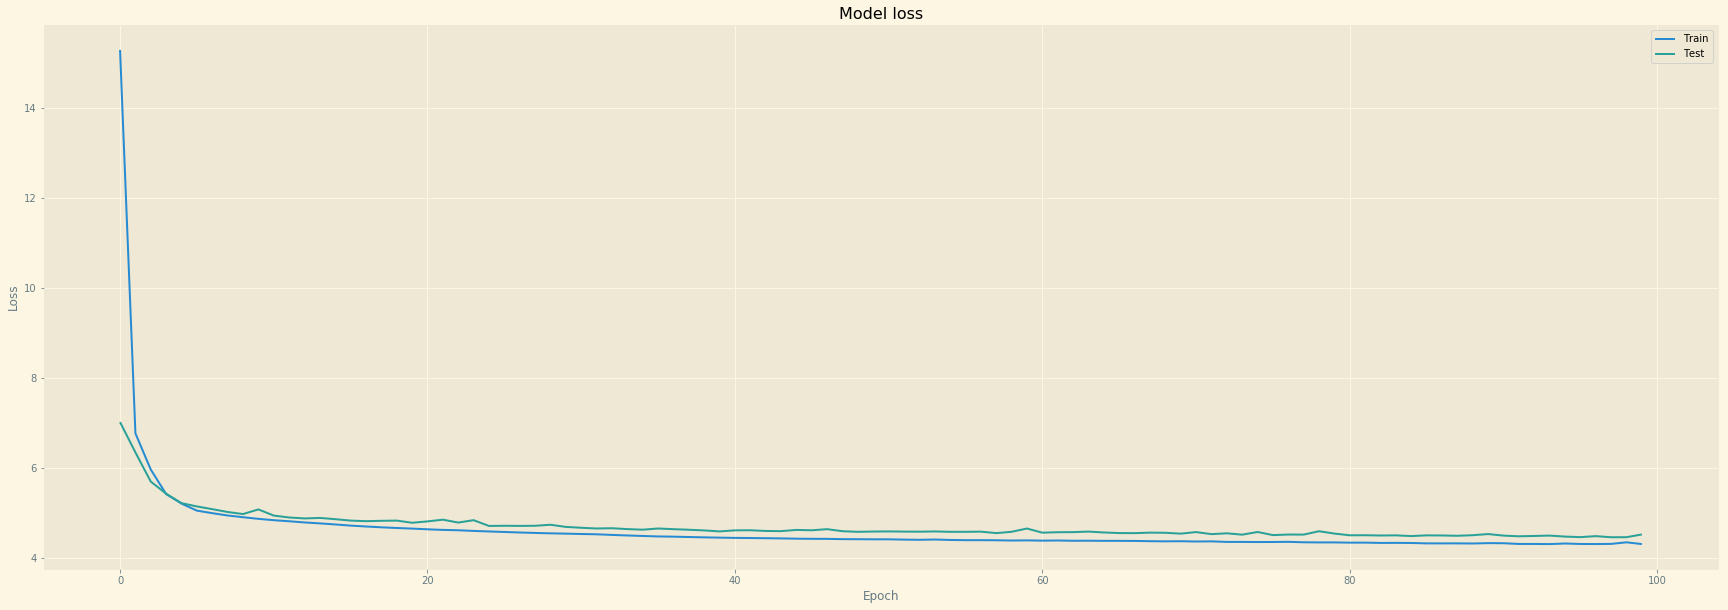

In [87]:
visualizer().loss_plot(history.history["loss"], history.history["val_loss"])
# visualizer.save_figure(history_img)

In [88]:
training_input_path = sagemaker.Session().upload_data(os.path.join(DATA_PATH, 'dataset2', 'train_data_' + suffix + '.pkl'), key_prefix='training')
print(training_input_path)

ValueError: Must setup local AWS configuration with a region supported by SageMaker.

In [60]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    base_job_name='sound-anomaly',
    entry_point='model.py',
    source_dir='.',
    role='AmazonSageMaker-ExecutionRole-20210114T163887',
    instance_count=1, 
    instance_type='ml.m5.24xlarge',
    framework_version='2.2',
    py_version='py37',
    hyperparameters={
        'epochs': 30,
        'batch-size': 512,
        'learning-rate': 1e-3,
        'n_mels': n_mels,
        'frame': frames
    },
    debugger_hook_config=False
)

In [62]:
tf_estimator.fit({'training': training_input_path})

2021-05-17 09:01:49 Starting - Starting the training job...
2021-05-17 09:02:11 Starting - Launching requested ML instancesProfilerReport-1621242072: InProgress
......
2021-05-17 09:03:19 Starting - Preparing the instances for training......
2021-05-17 09:04:32 Downloading - Downloading input data......
2021-05-17 09:05:32 Training - Training image download completed. Training in progress.2021-05-17 09:05:27.242948: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:425] Initializing the SageMaker Profiler.
2021-05-17 09:05:27.248906: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:106] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-05-17 09:05:27.415688: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:425] Initializing the SageMaker Profiler.
2021-05-17 09:05:31,186 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-17 09:05

In [ ]:
tf_endpoint_name = 'sound-anomaly-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
tf_predictor = tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large',
    endpoint_name=tf_endpoint_name
)
print(f'\nEndpoint name: {tf_predictor.endpoint_name}')